In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt             
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as Models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

2023-11-01 05:59:18.434125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 05:59:26.933144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 05:59:26.933261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 05:59:26.944658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 05:59:28.436060: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 05:59:28.438843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Loading data

In [2]:
IMAGE_SIZE = (228, 228)

BATCH_SIZE = 32

In [3]:
train_dir='seg_train/'
test_dir='seg_test/'

In [4]:
#Standardizig data
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.


In [5]:
#Standardizig data
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3000 files belonging to 6 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [7]:
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [8]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

## Visualizing dataset

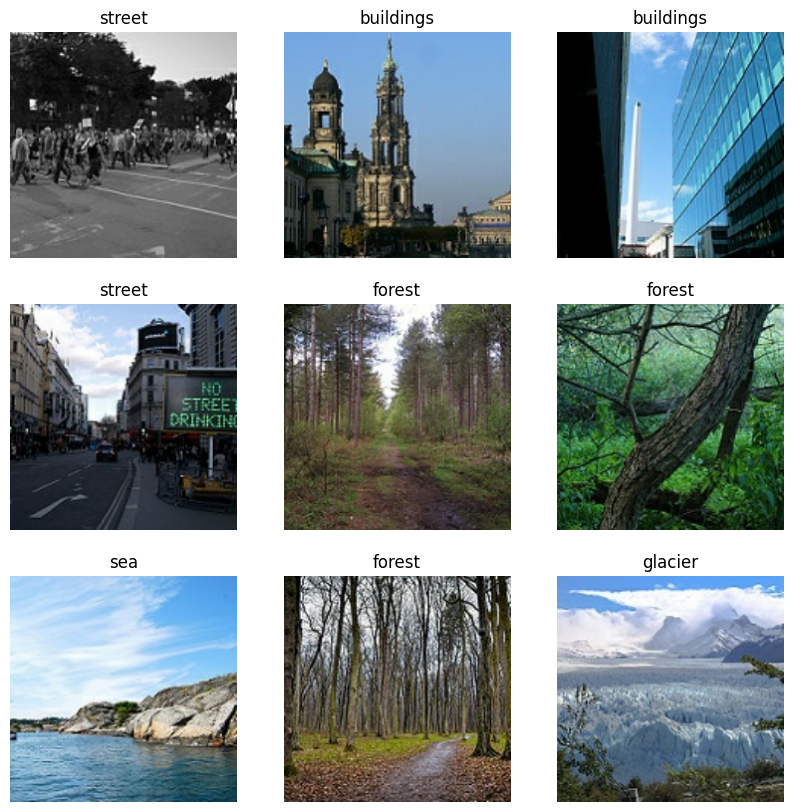

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## CNN model

Steps:
- Build the model,
- Compile the model,
- Train / fit the data to the model,
- Evaluate the model on the testing set,
- Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
- MaxPooling2D: The images get half sized.
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
- Relu : given a value x, returns max(x, 0).
- Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [23]:
num_classes = len(class_names)

In [35]:
model = Models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (228, 228, 3)))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 113, 113, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 64)       

In [37]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [38]:
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [39]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=35,
    callbacks=callback_list
)

Epoch 1/35
439/439 [==============================] - ETA: 0s - loss: 1.2867 - accuracy: 0.5539INFO:tensorflow:Assets written to: bestvalue/assets


INFO:tensorflow:Assets written to: bestvalue/assets


439/439 [==============================] - 430s 979ms/step - loss: 1.2867 - accuracy: 0.5539 - val_loss: 0.9923 - val_accuracy: 0.5833
Epoch 2/35
439/439 [==============================] - ETA: 0s - loss: 0.8736 - accuracy: 0.6668INFO:tensorflow:Assets written to: bestvalue/assets


INFO:tensorflow:Assets written to: bestvalue/assets


439/439 [==============================] - 460s 1s/step - loss: 0.8736 - accuracy: 0.6668 - val_loss: 0.8243 - val_accuracy: 0.6987
Epoch 3/35
439/439 [==============================] - ETA: 0s - loss: 0.7271 - accuracy: 0.7329INFO:tensorflow:Assets written to: bestvalue/assets


INFO:tensorflow:Assets written to: bestvalue/assets


439/439 [==============================] - 459s 1s/step - loss: 0.7271 - accuracy: 0.7329 - val_loss: 0.6896 - val_accuracy: 0.7563
Epoch 4/35
439/439 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7774INFO:tensorflow:Assets written to: bestvalue/assets


INFO:tensorflow:Assets written to: bestvalue/assets


439/439 [==============================] - 453s 1s/step - loss: 0.6236 - accuracy: 0.7774 - val_loss: 0.5933 - val_accuracy: 0.7853
Epoch 5/35
439/439 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.8034INFO:tensorflow:Assets written to: bestvalue/assets


INFO:tensorflow:Assets written to: bestvalue/assets


439/439 [==============================] - 449s 1s/step - loss: 0.5549 - accuracy: 0.8034 - val_loss: 0.5584 - val_accuracy: 0.8143
Epoch 6/35
439/439 [==============================] - 450s 1s/step - loss: 0.5002 - accuracy: 0.8234 - val_loss: 0.5803 - val_accuracy: 0.7973
Epoch 7/35
439/439 [==============================] - 447s 1s/step - loss: 0.4434 - accuracy: 0.8401 - val_loss: 0.5645 - val_accuracy: 0.8003
Epoch 8/35
439/439 [==============================] - 444s 1s/step - loss: 0.3966 - accuracy: 0.8572 - val_loss: 0.6479 - val_accuracy: 0.7897
Epoch 9/35
439/439 [==============================] - 449s 1s/step - loss: 0.3622 - accuracy: 0.8694 - val_loss: 0.6141 - val_accuracy: 0.8113
Epoch 10/35
439/439 [==============================] - 442s 1s/step - loss: 0.3323 - accuracy: 0.8809 - val_loss: 0.7007 - val_accuracy: 0.7907
Epoch 10: early stopping


In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 113, 113, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 64)       

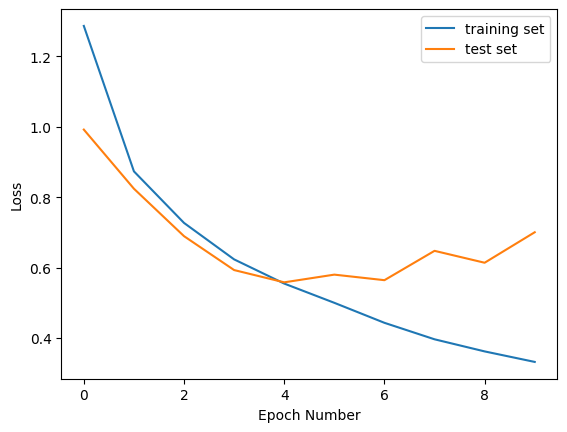

In [41]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

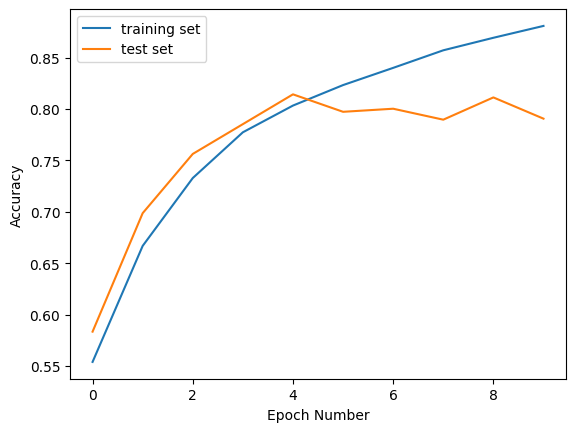

In [42]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [43]:
# load the prediction data and predict class on unseen data
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

pred_dir = 'seg_pred/'

images_paths = getImagePaths(pred_dir)
len(images_paths)

7301

In [44]:
# images path list to numpy array using cv2.imread module
file_array = []

for file in images_paths[:9]:
    img_ = image.load_img(file, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255. 
    file_array.append(img_processed)
    
file_array = np.array(file_array)

In [45]:
classes = train_ds.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [46]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 48ms/step


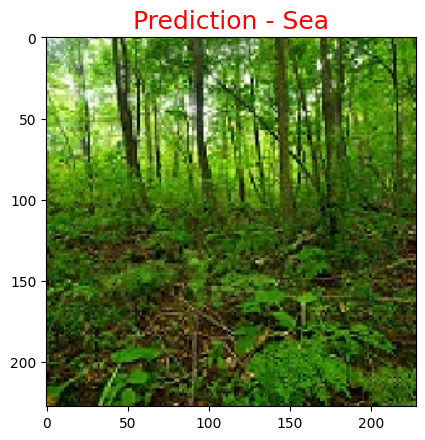

In [69]:
predict_image('seg_pred/10060.jpg', model)

## InceptionV3

In [58]:
##Trying InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(228,228, 3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

In [62]:
model_inc = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax")
])
model_inc.compile(loss='sparse_categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001) , metrics='accuracy')


In [63]:
hist_inc = model_inc.fit(train_ds ,
          validation_data = test_ds ,
          epochs = 15 ,
          steps_per_epoch = 901/32, # train_files/batch_size
          validation_steps = 224/32, # valid_files/batch_size 
          )

Epoch 1/15
28/28 [==============================] - 193s 6s/step - loss: 1.2452 - accuracy: 0.6767 - val_loss: 83.5545 - val_accuracy: 0.1875
Epoch 2/15
28/28 [==============================] - 181s 6s/step - loss: 0.8207 - accuracy: 0.7597 - val_loss: 1054.1310 - val_accuracy: 0.1786
Epoch 3/15
28/28 [==============================] - 179s 6s/step - loss: 0.6482 - accuracy: 0.7899 - val_loss: 26.6752 - val_accuracy: 0.1786
Epoch 4/15
28/28 [==============================] - 182s 6s/step - loss: 0.6008 - accuracy: 0.8071 - val_loss: 15.0062 - val_accuracy: 0.2500
Epoch 5/15
28/28 [==============================] - 184s 7s/step - loss: 0.6135 - accuracy: 0.7899 - val_loss: 2.4344 - val_accuracy: 0.4420
Epoch 6/15
28/28 [==============================] - 182s 6s/step - loss: 0.5113 - accuracy: 0.8244 - val_loss: 6.1988 - val_accuracy: 0.3929
Epoch 7/15
28/28 [==============================] - 181s 6s/step - loss: 0.4794 - accuracy: 0.8297 - val_loss: 1.9698 - val_accuracy: 0.5312
Epoch 8

1/1 [==============================] - 0s 67ms/step


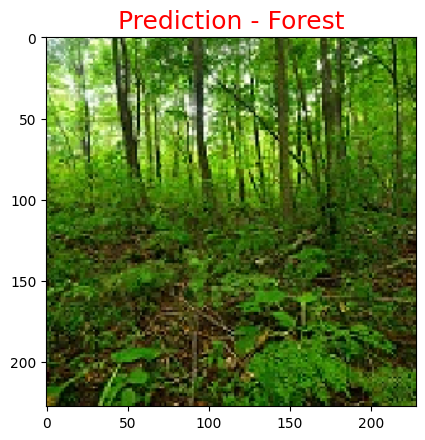

In [68]:
predict_image('seg_pred/10060.jpg', model_inc)